In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import scipy.io as sio
# import scipy.stats
import os
from time import time
import ieeg_funcs as ief
import dgFuncs as dg
from sklearn import svm
from sklearn import linear_model
from sklearn.externals import joblib

In [18]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
print(num_cores)

4


In [46]:
3/2
print(2/3)

0.6666666666666666


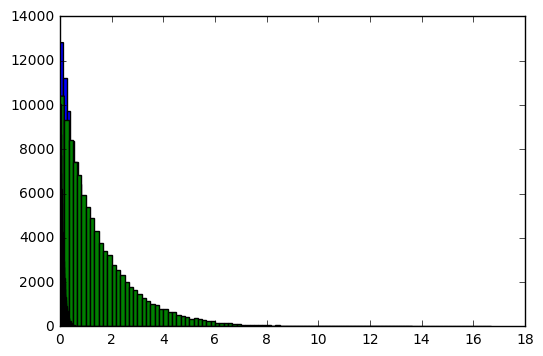

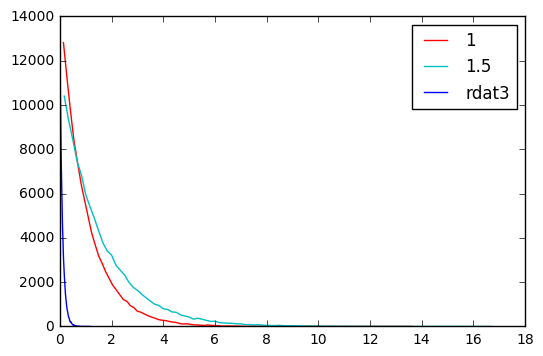

In [73]:
# scipy.stats.expon?
# rdat1=np.random.exponential(1,100000)
# rdat2=np.random.exponential(2/3,100000)
# rdat3=np.random.exponential(2,100000)
# As scale gets bigger, the distribution becomes more heavy tailed
rdat1=np.random.exponential(1,100000)
rdat2=np.random.exponential(3/2,100000)
rdat3=np.random.exponential(.1,100000)
plt.figure(1)
plt.clf()
bro1=plt.hist(rdat1,bins=100)
bro2=plt.hist(rdat2,bins=100)
bro3=plt.hist(rdat3,bins=100)

plt.figure(2)
plt.clf()
_=plt.plot(bro1[1][1:],bro1[0],'r-',label='1')
_=plt.plot(bro2[1][1:],bro2[0],'c-',label='1.5')
_=plt.plot(bro3[1][1:],bro3[0],'b-',label='rdat3')
# plt.xlim([0,5])
# plt.xscale('log')
plt.legend()

In [35]:
type(bro)
len(bro)
print(bro[0].shape)
print(bro[1].shape)

(100,)
(101,)


In [2]:
temp_ftrs=np.load('temp_ftrs.npz')
temp_ftrs.keys()

['sub_id', 'szr_class', 'ftrs']

In [3]:
mx_sub_id=int(np.max(temp_ftrs['sub_id']))

In [74]:
# Random Search
n_srch=10
exp_scale=0.1
C_ct=0
C_vals=np.zeros(n_srch)
train_sens=np.zeros((mx_sub_id,n_srch))
train_spec=np.zeros((mx_sub_id,n_srch))
train_bal_acc=np.zeros((mx_sub_id,n_srch))
valid_sens=np.zeros((mx_sub_id,n_srch))
valid_spec=np.zeros((mx_sub_id,n_srch))
valid_bal_acc=np.zeros((mx_sub_id,n_srch))

for C_ct in range(n_srch):
    C_vals[C_ct]=np.random.exponential(exp_scale,1)[0]
    print('%d/%d: C=%f' % (C_ct+1,n_srch,C_vals[C_ct]))
    start = time()
    for left_out_id in range(mx_sub_id):
        model = linear_model.LogisticRegression(class_weight='balanced', C=C_vals[C_ct])
        model.fit(temp_ftrs['ftrs'][temp_ftrs['sub_id']!=left_out_id,:],
                  temp_ftrs['szr_class'][temp_ftrs['sub_id']!=left_out_id])
        # make predictions from training and validation data
        training_class_hat = model.predict(temp_ftrs['ftrs'])
        jive=training_class_hat==temp_ftrs['szr_class']

        train_bool=temp_ftrs['sub_id']!=left_out_id
        valid_bool=temp_ftrs['sub_id']==left_out_id
        ictal_bool=temp_ftrs['szr_class']==1
        preictal_bool=temp_ftrs['szr_class']==0

        # Training Data Results
        use_ids=np.multiply(train_bool,ictal_bool)
        train_sens[left_out_id,C_ct]=np.mean(jive[use_ids])
#         print('Training sensitivity: %f' % train_sens[left_out_id,C_ct])
        use_ids=np.multiply(train_bool,preictal_bool)
        train_spec[left_out_id,C_ct]=np.mean(jive[use_ids])
#         print('Training specificity: %f' % train_spec[left_out_id,C_ct])
        train_bal_acc[left_out_id,C_ct]=(train_spec[left_out_id,C_ct]+train_sens[left_out_id,C_ct])/2
#         print('Training balanced accuracy: %f' % train_bal_acc[left_out_id,C_ct])

        # Validation Data Results
        use_ids=np.multiply(valid_bool,ictal_bool)
        valid_sens[left_out_id,C_ct]=np.mean(jive[use_ids])
        #print('Validation sensitivity: %f' % valid_sens[left_out_id,C_ct])
        use_ids=np.multiply(valid_bool,preictal_bool)
        valid_spec[left_out_id,C_ct]=np.mean(jive[use_ids])
        #print('Validation specificity: %f' % valid_spec[left_out_id,C_ct])
        valid_bal_acc[left_out_id,C_ct] = (valid_spec[left_out_id,C_ct] + valid_sens[left_out_id,C_ct]) / 2
        #print('Validation balanced accuracy: %f' % valid_bal_acc[left_out_id,C_ct])
    C_ct+=1

print("This block took %.2f seconds." % (time() - start))

1/10: C=0.078380
2/10: C=0.227551
3/10: C=0.004808
4/10: C=0.077046
5/10: C=0.039923
6/10: C=0.041412
7/10: C=0.060877
8/10: C=0.091147
9/10: C=0.144223
10/10: C=0.151379
This block took 13.45 seconds.


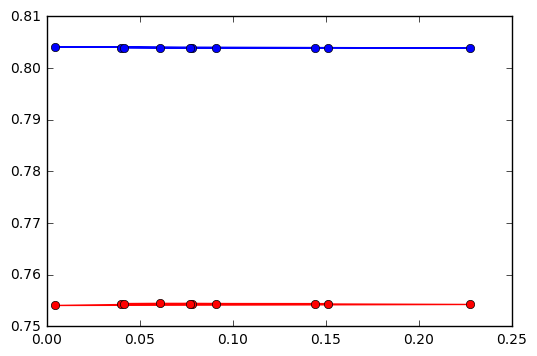

In [75]:
# Plot Random Search
plt.figure(1)
plt.clf()
plt.plot(C_vals,np.mean(train_bal_acc,axis=0),'b-o',label='Train')
plt.plot(C_vals,np.mean(valid_bal_acc,axis=0),'r-o',label='Valid')

In [5]:
# Iterative Search
max_n_srch=10
C_ini=10
div_fac=5
patience=3
steps_since_best=0
C_vals=np.zeros(max_n_srch)
train_sens=np.zeros((mx_sub_id,max_n_srch))
train_spec=np.zeros((mx_sub_id,max_n_srch))
train_bal_acc=np.zeros((mx_sub_id,max_n_srch))
valid_sens=np.zeros((mx_sub_id,max_n_srch))
valid_spec=np.zeros((mx_sub_id,max_n_srch))
valid_bal_acc=np.zeros((mx_sub_id,max_n_srch))
best_bal_acc=np.zeros(2)
best_models=None
for C_ct in range(max_n_srch):
    if C_ct==0:
        C_vals[C_ct]=C_ini
    else:
        C_vals[C_ct]=C_vals[C_ct-1]/div_fac
    print('%d/%d: C=%f' % (C_ct+1,max_n_srch,C_vals[C_ct]))
    start = time()
    temp_models=dict()
    for left_out_id in range(mx_sub_id):
        model = linear_model.LogisticRegression(class_weight='balanced', 
                                                C=C_vals[C_ct],
                                               penalty='l1')
        model.fit(temp_ftrs['ftrs'][temp_ftrs['sub_id']!=left_out_id,:],
                  temp_ftrs['szr_class'][temp_ftrs['sub_id']!=left_out_id])
        temp_models[left_out_id]=model
        # make predictions from training and validation data
        training_class_hat = model.predict(temp_ftrs['ftrs'])
        jive=training_class_hat==temp_ftrs['szr_class']

        train_bool=temp_ftrs['sub_id']!=left_out_id
        valid_bool=temp_ftrs['sub_id']==left_out_id
        ictal_bool=temp_ftrs['szr_class']==1
        preictal_bool=temp_ftrs['szr_class']==0

        # Training Data Results
        use_ids=np.multiply(train_bool,ictal_bool)
        train_sens[left_out_id,C_ct]=np.mean(jive[use_ids])
#         print('Training sensitivity: %f' % train_sens[left_out_id,C_ct])
        use_ids=np.multiply(train_bool,preictal_bool)
        train_spec[left_out_id,C_ct]=np.mean(jive[use_ids])
#         print('Training specificity: %f' % train_spec[left_out_id,C_ct])
        train_bal_acc[left_out_id,C_ct]=(train_spec[left_out_id,C_ct]+train_sens[left_out_id,C_ct])/2
#         print('Training balanced accuracy: %f' % train_bal_acc[left_out_id,C_ct])

        # Validation Data Results
        use_ids=np.multiply(valid_bool,ictal_bool)
        valid_sens[left_out_id,C_ct]=np.mean(jive[use_ids])
        #print('Validation sensitivity: %f' % valid_sens[left_out_id,C_ct])
        use_ids=np.multiply(valid_bool,preictal_bool)
        valid_spec[left_out_id,C_ct]=np.mean(jive[use_ids])
        #print('Validation specificity: %f' % valid_spec[left_out_id,C_ct])
        valid_bal_acc[left_out_id,C_ct] = (valid_spec[left_out_id,C_ct] + valid_sens[left_out_id,C_ct]) / 2
        #print('Validation balanced accuracy: %f' % valid_bal_acc[left_out_id,C_ct])
        
    if np.mean(valid_bal_acc[:,C_ct])>best_bal_acc[0]:
        best_bal_acc[0]=np.mean(valid_bal_acc[:,C_ct])
        best_bal_acc[1]=np.mean(train_bal_acc[:,C_ct])
        best_C=C_vals[C_ct]
        print('Best Validation Accuracy so far (valid/test): %f/%f' % (best_bal_acc[0],best_bal_acc[1]))
        best_models=temp_models
        steps_since_best=0
    else:
        steps_since_best+=1
        if steps_since_best>patience:
            print('Validation accuracy not improving. Exiting')
            break
    C_ct+=1

print("This block took %.2f seconds." % (time() - start))

1/10: C=10.000000
Best Validation Accuracy so far (valid/test): 0.754262/0.803891
2/10: C=2.000000
Best Validation Accuracy so far (valid/test): 0.754278/0.803898
3/10: C=0.400000
Best Validation Accuracy so far (valid/test): 0.754329/0.803914
4/10: C=0.080000
5/10: C=0.016000
Best Validation Accuracy so far (valid/test): 0.754388/0.804012
6/10: C=0.003200
Best Validation Accuracy so far (valid/test): 0.756432/0.804391
7/10: C=0.000640
Best Validation Accuracy so far (valid/test): 0.767536/0.801315
8/10: C=0.000128
9/10: C=0.000026
10/10: C=0.000005
This block took 2.00 seconds.


In [86]:
print(model.get_params())
print(best_model.get_params())
train_bal_acc.shape

{'penalty': 'l2', 'warm_start': False, 'n_jobs': 1, 'verbose': 0, 'class_weight': 'balanced', 'dual': False, 'random_state': None, 'multi_class': 'ovr', 'C': 0.0012345679012345679, 'fit_intercept': True, 'solver': 'liblinear', 'intercept_scaling': 1, 'tol': 0.0001, 'max_iter': 100}
{'penalty': 'l2', 'warm_start': False, 'n_jobs': 1, 'verbose': 0, 'class_weight': 'balanced', 'dual': False, 'random_state': None, 'multi_class': 'ovr', 'C': 0.10000000000000001, 'fit_intercept': True, 'solver': 'liblinear', 'intercept_scaling': 1, 'tol': 0.0001, 'max_iter': 100}


(7, 10)

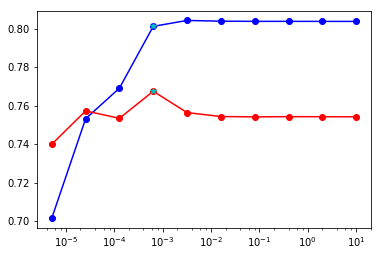

In [6]:
# Plot Iterative Search
plt.figure(1)
plt.clf()
plt.plot(C_vals[:C_ct],np.mean(train_bal_acc[:,:C_ct],axis=0),'b-o',label='Train')
plt.plot(C_vals[:C_ct],np.mean(valid_bal_acc[:,:C_ct],axis=0),'r-o',label='Valid')
plt.plot(best_C,best_bal_acc[0],'c*')
plt.plot(best_C,best_bal_acc[1],'c*')
plt.xscale('log')

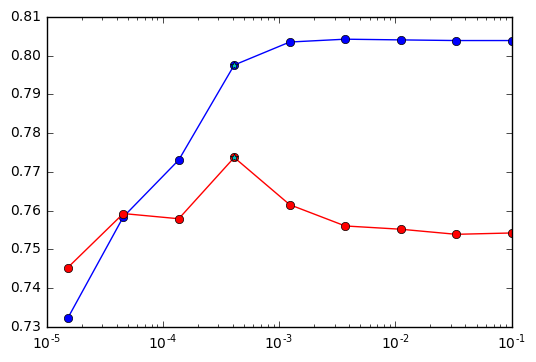

In [90]:
# Plot Iterative Search
plt.figure(1)
plt.clf()
plt.plot(C_vals[:C_ct],np.mean(train_bal_acc[:,:C_ct],axis=0),'b-o',label='Train')
plt.plot(C_vals[:C_ct],np.mean(valid_bal_acc[:,:C_ct],axis=0),'r-o',label='Valid')
plt.plot(best_C,best_bal_acc[0],'c*')
plt.plot(best_C,best_bal_acc[1],'c*')
plt.xscale('log')

In [92]:
wts=best_model.get_params()
wts.keys()

dict_keys(['penalty', 'warm_start', 'n_jobs', 'verbose', 'class_weight', 'dual', 'random_state', 'multi_class', 'C', 'fit_intercept', 'solver', 'intercept_scaling', 'tol', 'max_iter'])